# Import and downloading

In [1]:
!pip install rouge_score
!pip install py7zr

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=1e4706fc85af910335dd71d6c88c5c188fd21760fc4dab34fd73692a27597925
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 51.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.8/138.8 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 45.8 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 10.2 MB/s eta 0:00:00


In [2]:
!pip install -q bitsandbytes accelerate loralib datasets loralib 
!pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git

In [13]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import missingno as msno
import string

import re
import torch
import wandb
import nltk


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from datasets import load_metric, load_dataset
from wordcloud import WordCloud,STOPWORDS
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments 
from peft import LoraConfig, get_peft_model 
from nltk.translate.bleu_score import corpus_bleu
from peft import prepare_model_for_kbit_training 
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import pipeline
from transformers import DataCollatorForSeq2Seq
from transformers import TrainingArguments, Trainer

In [14]:
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

## EDA

In [16]:
train_ds_path = "/kaggle/input/samsum-dataset-text-summarization/samsum-train.csv"
test_ds_path = "/kaggle/input/samsum-dataset-text-summarization/samsum-test.csv"
val_ds_path = "/kaggle/input/samsum-dataset-text-summarization/samsum-validation.csv"

ds_name = "samsum"
train_df = pd.read_csv(train_ds_path)
test_df = pd.read_csv(test_ds_path)
val_df = pd.read_csv(val_ds_path)

train_df.head()

,id,dialogue,summary
0,13818513,Amanda: I baked cookies. Do you want some?\r\...,Amanda baked cookies and will bring Jerry some...
1,13728867,Olivia: Who are you voting for in this electio...,Olivia and Olivier are voting for liberals in ...
2,13681000,"Tim: Hi, what's up?\r\nKim: Bad mood tbh, I wa...",Kim may try the pomodoro technique recommended...
3,13730747,"Edward: Rachel, I think I'm in ove with Bella....",Edward thinks he is in love with Bella. Rachel...
4,13728094,Sam: hey overheard rick say something\r\nSam:...,"Sam is confused, because he overheard Rick com..."


In [17]:
val_df.head()

,id,dialogue,summary
0,13817023,"A: Hi Tom, are you busy tomorrow’s afternoon?\...",A will go to the animal shelter tomorrow to ge...
1,13716628,Emma: I’ve just fallen in love with this adven...,Emma and Rob love the advent calendar. Lauren ...
2,13829420,Jackie: Madison is pregnant\r\nJackie: but she...,Madison is pregnant but she doesn't want to ta...
3,13819648,Marla: <file_photo>\r\nMarla: look what I foun...,Marla found a pair of boxers under her bed.
4,13728448,Robert: Hey give me the address of this music ...,Robert wants Fred to send him the address of t...


In [18]:
test_df.head()

,id,dialogue,summary
0,13862856,"Hannah: Hey, do you have Betty's number?\nAman...",Hannah needs Betty's number but Amanda doesn't...
1,13729565,Eric: MACHINE!\r\nRob: That's so gr8!\r\nEric:...,Eric and Rob are going to watch a stand-up on ...
2,13680171,"Lenny: Babe, can you help me with something?\r...",Lenny can't decide which trousers to buy. Bob ...
3,13729438,"Will: hey babe, what do you want for dinner to...",Emma will be home soon and she will let Will k...
4,13828600,"Ollie: Hi , are you in Warsaw\r\nJane: yes, ju...",Jane is in Warsaw. Ollie and Jane has a party....


In [19]:
train_df['dialogue'] = train_df['dialogue'].astype('str')

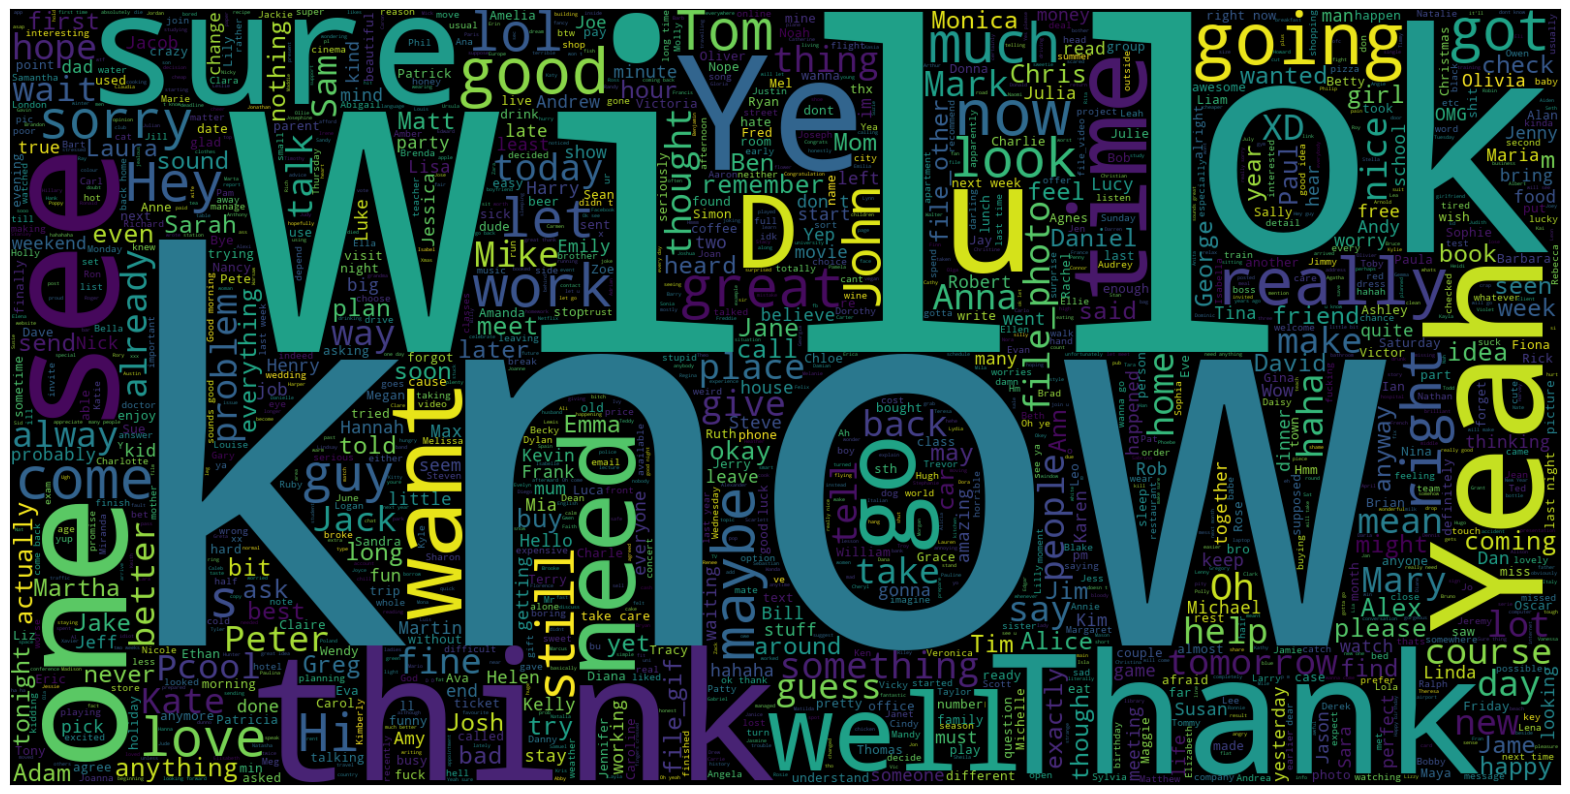

In [20]:
plt.figure(figsize=(20, 20)) 
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(' '.join(train_df['dialogue']))
plt.imshow(wc, interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.show()

## Preprocessing

In [21]:
print(train_df['dialogue'].iloc[14728])

Theresa: <file_photo>
Theresa: <file_photo>
Theresa: Hey Louise, how are u?
Theresa: This is my workplace, they always give us so much food here 😊
Theresa: Luckily they also offer us yoga classes, so all the food isn't much of a problem 😂
Louise: Hey!! 🙂 
Louise: Wow, that's awesome, seems great 😎 Haha
Louise: I'm good! Are you coming to visit Stockholm this summer? 🙂
Theresa: I don't think so :/ I need to prepare for Uni.. I will probably attend a few lessons this winter
Louise: Nice! Do you already know which classes you will attend?
Theresa: Yes, it will be psychology :) I want to complete a few modules that I missed :)
Louise: Very good! Is it at the Uni in Prague?
Theresa: No, it will be in my home town :)
Louise: I have so much work right now, but I will continue to work until the end of summer, then I'm also back to Uni, on the 26th September!
Theresa: You must send me some pictures, so I can see where you live :) 
Louise: I will, and of my cat and dog too 🤗
Theresa: Yeeeesss pl

**We can see that the text has tags like "file_photo" and so on. So I decided to clean the text of this since it doesn't affect the overall score.**

In [22]:
def clean_tags(text):
    clean = re.compile('<.*?>') # Compiling tags
    clean = re.sub(clean, '', text) # Replacing tags text by an empty string

    # Removing empty dialogues
    clean = '\n'.join([line for line in clean.split('\n') if not re.match('.*:\s*$', line)])

    return clean

def clean_df(df, cols):
    for col in cols:
        df[col] = df[col].fillna('').apply(clean_tags)
    return df

In [23]:
train_df = clean_df(train_df,['dialogue', 'summary'])
test_df = clean_df(test_df,['dialogue', 'summary'])
val_df = clean_df(val_df,['dialogue', 'summary'])
len(train_df)

14732

**Unfortunately our dataset is too big so I decided to trim it, this choice may affect the score but if we have a more powerful GPU we shouldn't use trimming.**

In [24]:
train_df = train_df[:int(len(train_df)*0.3)]
test_df = test_df[:int(len(test_df)*0.3)]
val_df = val_df[:int(len(val_df)*0.4)]
len(train_df)

4419

In [25]:
wandb.login(key='934dbc7b1d006602c7749e73cff768f43d4b010b')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

**I tried different models but this one gave a reliable high score with less memory and time**

# Modeling

In [26]:
model_name = "facebook/bart-large-cnn"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [27]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model = prepare_model_for_kbit_training(model)

In [28]:
def print_trainable_parameters(model): 
    """ 
    Prints the number of trainable parameters in the model. 
    """ 
    trainable_params = 0 
    all_param = 0 
    for _, param in model.named_parameters(): 
        all_param += param.numel() 
        if param.requires_grad: 
            trainable_params += param.numel() 
    print( 
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}" 
)

config = LoraConfig( 
    r=16, 
    lora_alpha=32, 
    target_modules=["q_proj", "v_proj"], 
    lora_dropout=0.05, 
    bias="none", 
    task_type="CAUSAL_LM" 
)

model = get_peft_model(model, config) 
print_trainable_parameters(model)

trainable params: 2359296 || all params: 408649728 || trainable%: 0.5773394274717344


In [29]:
pipe = pipeline('summarization', model = model_name)

pipe_out = pipe(test_df['dialogue'][1])

print(pipe_out)

[{'summary_text': "Rob: Is this his only stand-up? Eric: Sure. I'll check. Rob: Turns out no! There are some of his stand-ups on youtube. Eric: MACHINE! Rob: That's so gr8! Eric: Gr8! I'll watch them now!"}]


In [30]:
print(f"original summary:\n{test_df['summary'][1]}\n")
print("Predicted Summary:")
print(pipe_out[0]['summary_text'].replace(" .<n>", ".\n"))

original summary:
Eric and Rob are going to watch a stand-up on youtube.

Predicted Summary:
Rob: Is this his only stand-up? Eric: Sure. I'll check. Rob: Turns out no! There are some of his stand-ups on youtube. Eric: MACHINE! Rob: That's so gr8! Eric: Gr8! I'll watch them now!


In [31]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

In [32]:
def calculate_bleu(predictions, references):
    return corpus_bleu(references, predictions)

In [33]:
def calculate_metric_on_test_ds(dataset, metric, model, tokenizer, 
                               batch_size=16, device=device, 
                               column_text="article", 
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text].values.tolist(), batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary].values.tolist(), batch_size))
    
    
    bleu_scores = []
    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        
        inputs = tokenizer(article_batch, max_length=1024,  truncation=True, 
                        padding="max_length", return_tensors="pt")
        
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device), 
                         length_penalty=0.8, num_beams=8, max_length=128)
        
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, clean_up_tokenization_spaces=True) for s in summaries]      
        
        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]
        
        bleu_score = calculate_bleu(decoded_summaries, target_batch)
        bleu_scores.append(bleu_score)
        
        
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    avg_bleu_score = sum(bleu_scores) / len(bleu_scores)    
    score = metric.compute()
    
    return score, avg_bleu_score

In [34]:
rouge_metric = load_metric('rouge')

In [35]:
train_data = train_df['dialogue'].values.tolist()
train_data[:2]

["Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)",
 'Olivia: Who are you voting for in this election? \r\nOliver: Liberals as always.\r\nOlivia: Me too!!\r\nOliver: Great']

In [36]:
valid_data = val_df['dialogue'].values.tolist()
valid_data[:2]

["A: Hi Tom, are you busy tomorrow’s afternoon?\r\nB: I’m pretty sure I am. What’s up?\r\nA: Can you go with me to the animal shelter?.\r\nB: What do you want to do?\r\nA: I want to get a puppy for my son.\r\nB: That will make him so happy.\r\nA: Yeah, we’ve discussed it many times. I think he’s ready now.\r\nB: That’s good. Raising a dog is a tough issue. Like having a baby ;-) \r\nA: I'll get him one of those little dogs.\r\nB: One that won't grow up too big;-)\r\nA: And eat too much;-))\r\nB: Do you know which one he would like?\r\nA: Oh, yes, I took him there last Monday. He showed me one that he really liked.\r\nB: I bet you had to drag him away.\r\nA: He wanted to take it home right away ;-).\r\nB: I wonder what he'll name it.\r\nA: He said he’d name it after his dead hamster – Lemmy  - he's  a great Motorhead fan :-)))",
 'Emma: I’ve just fallen in love with this advent calendar! Awesome! I wanna one for my kids!\r\nRob: I used to get one every year as a child! Loved them! \r\nE

In [37]:
test_data = test_df['dialogue'].values.tolist()
test_data[:2]

["Hannah: Hey, do you have Betty's number?\nAmanda: Lemme check\nAmanda: Sorry, can't find it.\nAmanda: Ask Larry\nAmanda: He called her last time we were at the park together\nHannah: I don't know him well\nAmanda: Don't be shy, he's very nice\nHannah: If you say so..\nHannah: I'd rather you texted him\nAmanda: Just text him 🙂\nHannah: Urgh.. Alright\nHannah: Bye\nAmanda: Bye bye",
 "Eric: MACHINE!\r\nRob: That's so gr8!\r\nEric: I know! And shows how Americans see Russian ;)\r\nRob: And it's really funny!\r\nEric: I know! I especially like the train part!\r\nRob: Hahaha! No one talks to the machine like that!\r\nEric: Is this his only stand-up?\r\nRob: Idk. I'll check.\r\nEric: Sure.\r\nRob: Turns out no! There are some of his stand-ups on youtube.\r\nEric: Gr8! I'll watch them now!\r\nRob: Me too!\r\nEric: MACHINE!\r\nRob: MACHINE!\r\nEric: TTYL?\r\nRob: Sure :)"]

In [38]:
train_summary = train_df['summary'].values.tolist()
valid_summary = val_df['summary'].values.tolist()
test_summary = test_df['summary'].values.tolist()

In [39]:
def convert_examples_to_features(data, summary):
    input_encodings = tokenizer(data , max_length = 1024, truncation = True )
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(summary, max_length = 128, truncation = True )
        
    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }  

In [40]:
train_encodings = convert_examples_to_features(train_data, train_summary)
val_encodings = convert_examples_to_features(valid_data, valid_summary)
test_encodings = convert_examples_to_features(test_data, test_summary)

In [41]:
def data_transform(encode):
    l = []
    for i,j,k in zip(encode['input_ids'], encode['attention_mask'], encode['labels']):
        dic = {
            'input_ids': i,
            'attention_mask': j,
            'labels': k
        }
        l.append(dic)
        
    return l

train_encodings = data_transform(train_encodings)
val_encodings = data_transform(val_encodings)
test_encodings = data_transform(test_encodings)

In [42]:
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [43]:
torch.cuda.empty_cache()

In [44]:
trainer_args = Seq2SeqTrainingArguments(
    output_dir = 'bart_samsum',
    evaluation_strategy = "epoch",
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_loss',
    learning_rate=1e-3,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=1,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=1,
    predict_with_generate=True,
    fp16=True,
    report_to="none"
)
trainer = Seq2SeqTrainer(model=model, 
                  args=trainer_args,
                  tokenizer=tokenizer, 
                  data_collator=seq2seq_data_collator,
                  train_dataset=train_encodings, 
                  eval_dataset=val_encodings)

In [45]:
trainer.train()

You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,1.425700,1.440539


TrainOutput(global_step=4419, training_loss=1.4975208732223424, metrics={'train_runtime': 637.5773, 'train_samples_per_second': 6.931, 'train_steps_per_second': 6.931, 'total_flos': 1482075578523648.0, 'train_loss': 1.4975208732223424, 'epoch': 1.0})

In [46]:
score, avg_bleu_score = calculate_metric_on_test_ds(
    test_df, rouge_metric, trainer.model, tokenizer, batch_size = 2, column_text = 'dialogue', column_summary= 'summary'
)

100%|██████████| 123/123 [03:24<00:00,  1.66s/it]


In [47]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )
    
pd.DataFrame(rouge_dict, index = [f'pegasus'] )

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.013476,0.000199,0.013476,0.013489


In [48]:
print("Average BLEU Score:", avg_bleu_score)

Average BLEU Score: 0.4792395075434682


**This scores were received before LoRA**

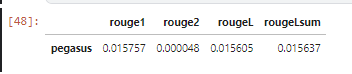

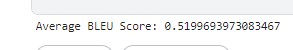

**This scores were received after LoRA**

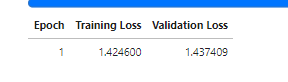

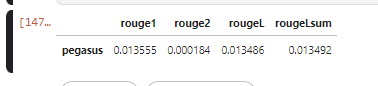

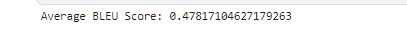

**After using LoRA we see a decrease in scores (BLEU, ROUGE), so LoRA can improve scores and learning, but not too much.**

BLEU:

Pros: BLEU measures the overlap between the generated summary and reference summaries. Higher BLEU scores indicate better matches with references.
Cons: BLEU does not consider synonyms or different word orders, making it sensitive to minor phrasing variations.

ROUGE:

Pros: ROUGE evaluates overlap between generated and reference summaries, considering multiple metrics like ROUGE-N, ROUGE-L, and ROUGE-W.
Cons: Similar to BLEU, ROUGE is sensitive to phrasing differences and does not capture semantic similarity well.

BLEU focuses on precision: how much the words (and/or n-grams) in the candidate model outputs appear in the human reference.
ROUGE focuses on recall: how much the words (and/or n-grams) in the human references appear in the candidate model outputs.
These results are complementing, as is often the case in the precision-recall tradeoff.

In [49]:
model.save_pretrained("model")
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.json',
 'tokenizer/merges.txt',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

In [52]:
tokenizer = AutoTokenizer.from_pretrained("/kaggle/working/tokenizer")
model = "/kaggle/working/model"

In [57]:
sumarizier = pipeline("summarization", model=model,tokenizer=tokenizer)

In [62]:
sample_text = test_df['dialogue'][23]
orig_sum = test_df['summary'][23]
predicted_summary = sumarizier(sample_text)[0]["summary_text"]

print("Dialogue:")
print(sample_text)

print("\nReference Summary:")
print(orig_sum)

print("\nModel Summary:")
print(predicted_summary)

Your max_length is set to 142, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Dialogue:
Anne: You were right, he was lying to me :/
Irene: Oh no, what happened?
Jane: who? that Mark guy?
Anne: yeah, he told me he's 30, today I saw his passport - he's 40
Irene: You sure it's so important?
Anne: he lied to me Irene

Reference Summary:
Mark lied to Anne about his age. Mark is 40.

Model Summary:
Anne: You were right, he was lying to me :/                 Irene: Oh no, what happened?                Jane: who? that Mark guy?                Anne: yeah, he told me he's 30, today I saw his passport - he's 40.


In [63]:
sample_text = test_df['dialogue'][2]
orig_sum = test_df['summary'][2]
predicted_summary = sumarizier(sample_text)[0]["summary_text"]

print("Dialogue:")
print(sample_text)

print("\nReference Summary:")
print(orig_sum)

print("\nModel Summary:")
print(predicted_summary)

Dialogue:
Lenny: Babe, can you help me with something?
Bob: Sure, what's up?
Lenny: Which one should I pick?
Bob: Send me photos
Bob: I like the first ones best
Lenny: But I already have purple trousers. Does it make sense to have two pairs?
Bob: I have four black pairs :D :D
Lenny: yeah, but shouldn't I pick a different color?
Bob: what matters is what you'll give you the most outfit options
Lenny: So I guess I'll buy the first or the third pair then
Bob: Pick the best quality then
Lenny: ur right, thx
Bob: no prob :)

Reference Summary:
Lenny can't decide which trousers to buy. Bob advised Lenny on that topic. Lenny goes with Bob's advice to pick the trousers that are of best quality.

Model Summary:
Lenny asks Bob to help him pick a new pair of trousers. Lenny already has purple trousers. Bob has four black pairs. Bob says he'll buy the first or the third pair then pick the best quality then. The pair decide on the first pair of black trousers.


In [66]:
sample_text = """Summarize: Water on Mars has been a topic of immense interest and exploration, primarily due to its importance for potential future human missions and its significance in understanding the planet's history. Here's a 250-word text discussing how water can be found on Mars:
Water on Mars has long captivated the imagination of scientists and space enthusiasts alike. While the Red Planet's surface may seem arid and desolate, evidence suggests that water exists in various forms. Discovering water on Mars has far-reaching implications for future missions and our understanding of the planet's past.
One of the most compelling pieces of evidence for water on Mars is the presence of polar ice caps. These caps are primarily composed of water ice, which freezes out of the thin Martian atmosphere during the planet's cold winters. The polar ice caps' size and behavior vary with the changing seasons, offering a dynamic view of Martian water.
Mars also boasts extensive underground water ice. Radar data from spacecraft like the Mars Reconnaissance Orbiter have revealed subsurface ice deposits, often buried beneath a layer of dust and rock. These reservoirs could potentially serve as a vital resource for future human missions, offering drinking water and even a source of oxygen for life support systems.
Additionally, Martian geology provides clues about the planet's watery past. Dry riverbeds, deltas, and ancient lakebeds hint at a once-watery world, where liquid water flowed across the surface. These features suggest that Mars may have experienced a warmer, wetter climate in its distant past, making it a potential candidate for past habitability.
Water on Mars, in various forms, continues to be a focal point of scientific exploration and future colonization plans. Its existence fuels our curiosity about the planet's history and its potential to support human life. Understanding how water can be harnessed and utilized on Mars remains a pivotal part of our endeavors to explore the mysteries of the Red Planet.
"""
orig_sum = """Water on Mars has long captivated the imagination of scientists and space enthusiasts alike. While the Red Planet's surface may seem arid and desolate, evidence suggests that water exists in various forms. Discovering water has far-reaching implications for future missions and our understanding of the planet's past."""
predicted_summary = sumarizier(sample_text)[0]["summary_text"]

print("Dialogue:")
print(sample_text)

print("\nReference Summary:")
print(orig_sum)

print("\nModel Summary:")
print(predicted_summary)

Dialogue:
Summarize: Water on Mars has been a topic of immense interest and exploration, primarily due to its importance for potential future human missions and its significance in understanding the planet's history. Here's a 250-word text discussing how water can be found on Mars:
Water on Mars has long captivated the imagination of scientists and space enthusiasts alike. While the Red Planet's surface may seem arid and desolate, evidence suggests that water exists in various forms. Discovering water on Mars has far-reaching implications for future missions and our understanding of the planet's past.
One of the most compelling pieces of evidence for water on Mars is the presence of polar ice caps. These caps are primarily composed of water ice, which freezes out of the thin Martian atmosphere during the planet's cold winters. The polar ice caps' size and behavior vary with the changing seasons, offering a dynamic view of Martian water.
Mars also boasts extensive underground water ice.

In [67]:
sample_text = """Summarize: Tell me about your home. The one who remembers your first faltering steps and preserves the annual notches of time left by your mother's hand on the door.
Tell me about its smell - the warm sleepy spirit of bookshelves, a credenza battered with shachel, yellow soup with astringent parsley. Or, perhaps, on the contrary - the cheerful fragrance of paint, varnish, novelty; how long, if not half my life, I dreamed of my own home!
Tell about his creaks and rustles, shadows and light-filled rooms, carefree laughter or cracked voices that suddenly spoke in a low voice that, probably, nothing would be the same again.
Furrowed, scarred, with cross-glued windows, your house, defenseless during a great calamity, now tries with all its might to be a fortress: somewhere in its bowels - in a dark, uncomfortable basement - people and domestic animals often hide from shelling.
And sometimes the house can fit into the size of a suitcase. All of us now, like those snails, know the price of large migrations.
But the main thing is the place of power and memory of the family. Your predecessors, who were ground by the millstones of the dark times, drew strength from it - wars, repressions, the struggle with the two-headed hydra. They were broken, and they fought for the right to survive and keep their home within themselves. That's how we are now.
I know for sure, he will stand up, fight it out, wait for your excited exclamation: "I'm home!". And you will tell me about everything.
"""
predicted_summary = sumarizier(sample_text)[0]["summary_text"]

print("Dialogue:")
print(sample_text)

print("\nModel Summary:")
print(predicted_summary)

Dialogue:
Summarize: Tell me about your home. The one who remembers your first faltering steps and preserves the annual notches of time left by your mother's hand on the door.
Tell me about its smell - the warm sleepy spirit of bookshelves, a credenza battered with shachel, yellow soup with astringent parsley. Or, perhaps, on the contrary - the cheerful fragrance of paint, varnish, novelty; how long, if not half my life, I dreamed of my own home!
Tell about his creaks and rustles, shadows and light-filled rooms, carefree laughter or cracked voices that suddenly spoke in a low voice that, probably, nothing would be the same again.
Furrowed, scarred, with cross-glued windows, your house, defenseless during a great calamity, now tries with all its might to be a fortress: somewhere in its bowels - in a dark, uncomfortable basement - people and domestic animals often hide from shelling.
And sometimes the house can fit into the size of a suitcase. All of us now, like those snails, know the p